## Let's build and learn the usage of pinecone (and CLIP too)

Note : Setup your environment by following the README, and avoid using the requirements file. Without the setup, there's a high chance of running into errors.

Warning : Make sure you are using a free tier pinecone index. The author of this notebook is not liable to any cost you incur.

Step1 : Preparing our Dataset

In [1]:
import os
import json
from dotenv import load_dotenv
_ = load_dotenv()


dataset_folder = 'dataset'
memes_dataset = []

# Modify this to change the dataset size. Note : 100,000 is the pinecone starter limit.
first_n = 25

for file_name in os.listdir(dataset_folder):
    # Check if the file is a JSON file
    if file_name.endswith('.json'):
        file_path = os.path.join(dataset_folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            # Add only the first n memes from each file to the dataset
            memes_dataset.extend(data[:first_n])

# Process the dataset to the desired format
processed_memes_dataset = [{
    "description": " ".join(meme["boxes"]),
    "url": meme["url"]
} for meme in memes_dataset]

# Print the number of memes and the first few entries to verify
print(f"Total memes processed: {len(processed_memes_dataset)}")
print(processed_memes_dataset[:5])

Total memes processed: 650
[{'description': 'WHEN YOU HEAR YOUR VOICE FROM AN OLD VIDEO', 'url': 'https://i.imgflip.com/3bu65e.jpg'}, {'description': 'WHEN YOU MAKE AN ACTUAL FUNNY MEME AND NOBODY LIKES IT', 'url': 'https://i.imgflip.com/3nu05r.jpg'}, {'description': "I WAS GOING TO SUBMIT A JOKE ABOUT TIME TRAVEL BUT YOU GUYS DIDN'T LIKE IT", 'url': 'https://i.imgflip.com/2bnvvz.jpg'}, {'description': "BEING RAISED BY A SINGLE MOTHER, SHE TAUGHT ME HOW TO SHAVE, RESPECT WOMEN AND COOKING,... EVENTUALLY I LEARNED MEN DON'T SHAVE THEIR LEGS", 'url': 'https://i.imgflip.com/29r47t.jpg'}, {'description': 'WHEN PORCH THIEVES STEAL YOUR PACKAGE AND LOOK INSIDE IT AND PUT IT BACK', 'url': 'https://i.imgflip.com/2rnaob.jpg'}]


Step2 : Initialising pinecone index

In [2]:
from pinecone import Pinecone, PodSpec

api_key = os.environ.get("PINECONE_API_KEY")
index_name = "starter-index-meme-search"

# Initialize Pinecone
pc = Pinecone(api_key=api_key)

# Create a Pinecone index with the appropriate environment for the starter tier
# Since we are using CLIP which produces 512-dimensional vectors, we'll set the dimension to 512.
if index_name not in  pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,
        metric="cosine",
        spec=PodSpec(environment="gcp-starter")
    )

# Connect to the newly created or existing index
meme_index = pc.Index(name=index_name)

d:\Purdue\Academics\Spring\Industry Practicum\LLM-Marketing-agent\ipvenv\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Step3 : Load the CLIP Model

In [3]:
import clip
import torch
from PIL import Image
import requests
from io import BytesIO

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
clip_model, preprocess = clip.load("ViT-B/32", device=device)

cuda


Step4 : Process Images and Upload to Pinecone

In [4]:
def process_and_upload_image(image_url, index):
    try:
        # Download the image
        response = requests.get(image_url)
        response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
        image = Image.open(BytesIO(response.content))
        
        # Preprocess the image and generate embedding
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
            image_embedding = image_features.cpu().numpy().tolist()[0]
        
        # The upsert method updates the vector if the id already exists, preventing duplicates.
        index.upsert(vectors=[(image_url, image_embedding)])
        
    except requests.exceptions.RequestException as e:
        # This will catch HTTPError and other request exceptions
        print(f"Failed to download {image_url}: {e}")
    except Exception as e:
        # This will catch other exceptions, such as errors during image preprocessing or upserting.
        print(f"An error occurred for {image_url}: {e}")

Step5 : Query with text

In [5]:
def search_meme(query, index, top_k = 1):
    # Convert query to embedding
    text_input = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_input)
        text_embedding = text_features.cpu().numpy().tolist()[0]
    
    # Search in Pinecone
    try:
        results = index.query(vector=[text_embedding], top_k=top_k)
    except Exception as e:
        print(f"An error occurred: {e}")
    
    for match in results["matches"]:
        print(f"URL: {match['id']}, Score: {match['score']}")
    
    return results["matches"]

## Example usage

Processing memes and storing to pinecone

In [6]:
for meme in processed_memes_dataset:
    process_and_upload_image(meme['url'], meme_index)

Failed to download https://i.imgflip.com/3x4wfv.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3x4wfv.jpg
Failed to download https://i.imgflip.com/3yt6d0.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3yt6d0.jpg
Failed to download https://i.imgflip.com/3xzrkg.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3xzrkg.jpg
Failed to download https://i.imgflip.com/3n29ka.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3n29ka.jpg
Failed to download https://i.imgflip.com/3o16fp.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3o16fp.jpg
Failed to download https://i.imgflip.com/3x2254.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3x2254.jpg
Failed to download https://i.imgflip.com/3ydf3b.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3ydf3b.jpg
Failed to download https://i.imgflip.com/3ypbhh.jpg: 404 Client Error: Not Found for url: https://i.imgflip.com/3ypbhh.jpg
Failed to downlo

Testing the search functionality

URL: https://i.imgflip.com/3zf4id.jpg, Score: 0.264264584


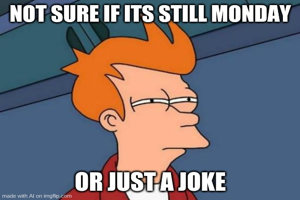

In [23]:
from IPython.display import display, Image as IPImage
from PIL import Image

query_text = "That moment when you realize it's only Tuesday"

search_results = search_meme(query_text, meme_index, top_k=1)
if search_results:
    # Assuming the first result is the most relevant
    meme_url = search_results[0]['id']
    response = requests.get(meme_url)
    img = Image.open(BytesIO(response.content))

# Resizing for jupyter
img = img.resize((300, 200))
display(img)
    